0.8817641986511247
0.8782943626592589
Total final euros: 35342208.08812989
Buy times:  []
Sell times:  [0.41, 2.23, 2.33, 2.44, 2.54]
Buy prices:  []
Sell prices:  [0.8817641986511247, 0.8817641986511247, 0.8833937512572393, 0.884073968892509, 0.8848753162585945]
End dollar: 0
End number of euros: 35342208.08812989


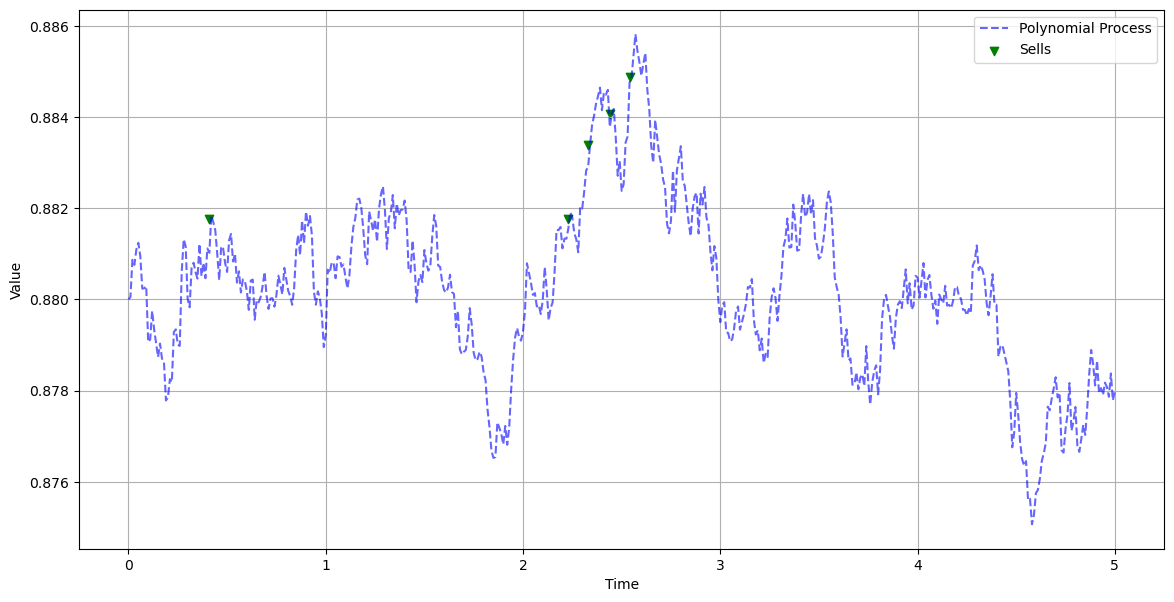

0.8817641986511247
0.8782943626592589
35319731.40730541
0
0.8817641986511247
0.8782943626592589
35279643.45552034
10000000
0.8817641986511247
0.8782943626592589
35332247.8983873
0
0.8817641986511247
0.8782943626592589
35316032.78494922
0
0.8817641986511247
0.8782943626592589
35302140.46293305
0
0.8817641986511247
0.8782943626592589
35339620.57943907
0
0.8817641986511247
0.8782943626592589
35317534.11894101
0
0.8817641986511247
0.8782943626592589
35313344.545446604
0
0.8817641986511247
0.8782943626592589
35307529.948181115
0
0.8817641986511247
0.8782943626592589
35341773.62717832
0
Max euros:  [35408815.30495261, 35400708.46191451, 35419860.37496236, 35378978.88147055, 35345720.33066683, 35407787.36521787, 35398991.880421616, 35421590.89709132, 35349043.574277334, 35393485.95643037]
End euros:  [35319731.40730541, 35279643.45552034, 35332247.8983873, 35316032.78494922, 35302140.46293305, 35339620.57943907, 35317534.11894101, 35313344.545446604, 35307529.948181115, 35341773.62717832]
End

<function matplotlib.pyplot.show(close=None, block=None)>

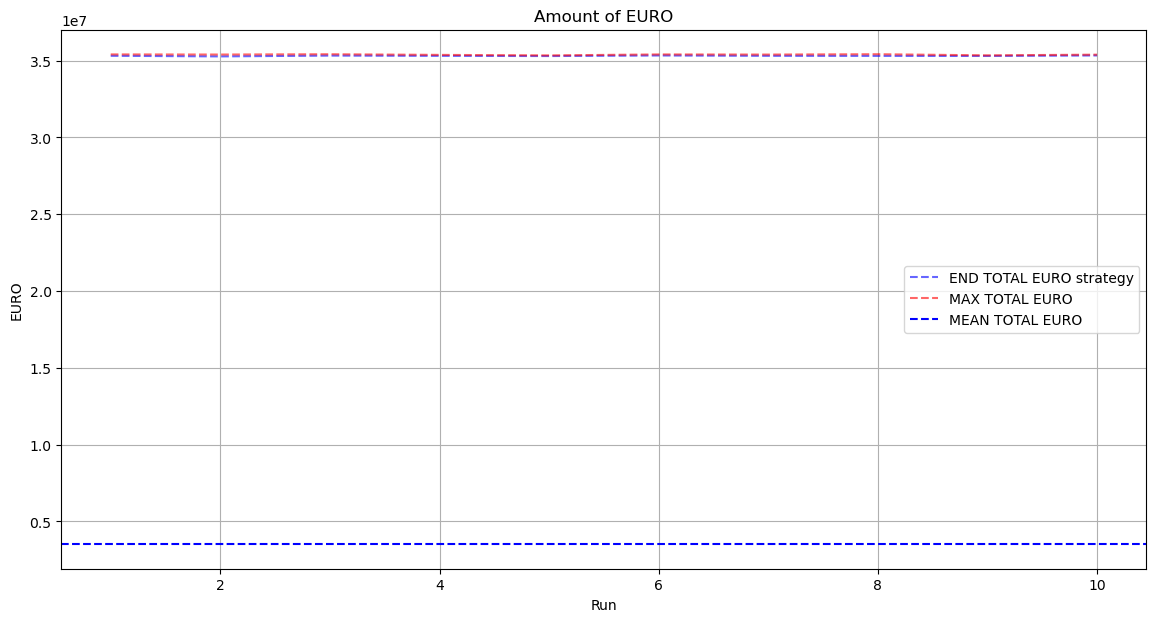

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.optimize import brentq
from mpmath import mp
from functools import lru_cache
from scipy.optimize import root_scalar
mp.dps = 10

# Parameters
theta = 3
mu = 0
sigma = 0.05
x_0_init = 0
p_0, p_1, p_2, p_3 = 0.88, 0.1, 0.1, 0.5
degree = 3
T = 5
m = 500
time_points = np.linspace(0, T, m + 1)
L, R = 0, 100
x_COS = np.linspace(L, R, 1000)
N = 512

# Capital
dollars = 40000000
euros = 0

# Target
target_prob = 0.8
a_bounds = (0.5, 1.5)
b_bounds = (0.5, 1.5)

# Polynomial inversion

def inv_poly(x):
    coeffs = [p_3, p_2, p_1, p_0 - x]
    roots = np.roots(coeffs)
    real_roots = roots[np.isreal(roots)].real
    return real_roots[np.argmax(real_roots)]  # Take the largest real root

# Characteristic functions

def phi_upper(u, a, x_0):
    y1 = ((mu - x_0) * np.sqrt(2 * theta)) / sigma
    y2 = ((mu - inv_poly(a)) * np.sqrt(2 * theta)) / sigma
    exp_factor = np.exp((theta * (x_0 - mu) ** 2 - theta * (inv_poly(a) - mu) ** 2) / (2 * sigma ** 2))
    v = mp.mpc(0., -u / theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def phi_lower(u, b, x_0):
    mu_adj = 2 * x_0 - mu 
    y1 = ((mu_adj - x_0) * np.sqrt(2 * theta)) / sigma
    y2 = ((mu_adj - (2 * x_0 - inv_poly(b))) * np.sqrt(2 * theta)) / sigma
    exp_factor = np.exp((theta * (x_0 - mu_adj) ** 2 - theta * ((2 * x_0 - inv_poly(b)) - mu_adj) ** 2) / (2 * sigma ** 2))
    v = mp.mpc(0., -u / theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))



# COS density

def COSDensity(phi,x,N,R,L,q,p):
    sum = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi(k*np.pi/(R-L),q,p ) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k = 0.5 * F_k
        else:
            F_k = F_k
        F_k = F_k *np.exp(np.log(10**(-16))*(k/N)**6)
        sum += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum

# Hitting probability
def hitting_probability(func, barrier, x_0):
    pdf = COSDensity(func, x_COS, N, R,L, barrier,x_0)
    mask = x_COS <= 1
    return simps(pdf[mask], x_COS[mask])

# Faster barrier distance calculation
def find_price_barrier(phi_func, x_0, P_x0, direction='upper', max_barrier=0.05):
    def obj(barrier):
        return hitting_probability(phi_func, barrier, x_0) - target_prob

    if direction == 'upper':
        bracket = [P_x0 + 0.0001, P_x0 + max_barrier]
    else:  # 'lower'
        bracket = [P_x0 - max_barrier, P_x0 - 0.0001]

    sol = root_scalar(obj, bracket=bracket, method='brentq', rtol=1e-5)
    return sol.root


# Simulate

def simulate_POLY_OU_process():
    dt = T / m
    OU_path = np.zeros(m + 1)
    POLY_path = np.zeros(m + 1)
    OU_path[0] = x_0_init
    POLY_path[0] = p_0 + p_1 * x_0_init + p_2 * x_0_init ** 2 + p_3 * x_0_init ** 3
    dW = np.sqrt(dt) * np.random.normal(0, 1, m)
    dollars_local, euros_local = dollars, euros
    x_0 = x_0_init
    P_x0 = p_0 + p_1 * x_0 + p_2 * x_0 ** 2 + p_3 * x_0 ** 3

    last_trade_time = -np.inf  # initialize with a very small value
    min_trade_interval = 0.1  # days

    a = find_price_barrier(phi_upper, x_0, P_x0, direction='upper')
    b = find_price_barrier(phi_lower, x_0, P_x0, direction='lower')
    x_a = a
    x_b = b
    print(a)
    print(b)
    
    buy_times = []
    sell_times = []
    buy_prices = []
    sell_prices = []

    for j in range(m):
        current_time = (j / m) * T
        x_next = OU_path[j] + theta * (mu - OU_path[j]) * dt + sigma * dW[j]
        OU_path[j + 1] = x_next
        P_x = p_0 + p_1 * x_next + p_2 * x_next ** 2 + p_3 * x_next ** 3
        POLY_path[j + 1] = P_x

        if current_time - last_trade_time >= min_trade_interval:

            if P_x >= a and dollars_local >= 5000000:
                if 0.88 < a <= x_a:
                    dollars_local -= 5000000
                    euros_local += 5000000 * P_x
                    last_trade_time = current_time
                    x_start = x_next
                    sell_prices.append(a)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    if b > 0.88:
                        print(f"[Adjustment] Lower barrier {b:.4f} is above 0.88. Resetting to 0.88.")
                        b = 0.88
                    sell_times.append(np.round((j/m)*T,3))
                elif a != 0.88 and a > x_a and dollars_local >= 10000000:
                    dollars_local -= 10000000
                    euros_local += 10000000 * P_x
                    last_trade_time = current_time
                    x_start = x_next
                    sell_prices.append(P_x)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    if b > 0.88:
                        print(f"[Adjustment] Lower barrier {b:.4f} is above 0.88. Resetting to 0.88.")
                        b = 0.88
                    sell_times.append(np.round((j/m)*T,3))
                elif a != 0.88 and a > x_a and dollars_local >= 5000000:
                    dollars_local -= 5000000
                    euros_local += 5000000 * P_x
                    last_trade_time = current_time
                    x_start = x_next
                    sell_prices.append(P_x)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    if b > 0.88:
                        print(f"[Adjustment] Lower barrier {b:.4f} is above 0.88. Resetting to 0.88.")
                        b = 0.88
                    sell_times.append(np.round((j/m)*T,3))
                else:
                    x_start = x_next
                    a = x_a
                    b = x_b
                        
            elif P_x <= b:
                if b >=  0.88:
                    x_start = x_next
                    buy_prices.append(b)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    buy_times.append(np.round((j/m)*T, 3))
    
                else:
                    a = x_a
                    b = b - 1
            else:
                continue

        else: 
            continue

    return OU_path, POLY_path, dollars_local, euros_local, buy_times, sell_times, buy_prices, sell_prices

# Run simulation
"""
if a < 0.88:
                    print(f"[Adjustment] Upper barrier {a:.4f} is below 0.88. Resetting to 0.88.")
                    a = 0.88
"""

OU_path, POLY_path, end_dollars, end_euros, buy_times, sell_times, buy_prices, sell_prices = simulate_POLY_OU_process()
final_euros =  end_dollars * POLY_path[-1] + end_euros 
print('Total final euros:', final_euros)
print("Buy times: " ,buy_times)
print("Sell times: " ,sell_times)
print("Buy prices: " ,buy_prices)
print("Sell prices: " ,sell_prices)
print("End dollar:", end_dollars)
print("End number of euros:", end_euros)

# Plot

dt = T / m
plt.figure(figsize=(14, 7))
#plt.plot(time_points, OU_path, 'r-', alpha=0.6, label='OU Process')
plt.plot(time_points, POLY_path, 'b--', alpha=0.6, label='Polynomial Process')
plt.scatter(sell_times, sell_prices, color='green', marker='v', label='Sells')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

list_of_end_euros = []
list_of_max_end_euros = []
list_of_end_dollars = []
mean_end_dollars = 3520000


for i in range(10):
    OU_path, POLY_path, end_dollars, end_euros, buy_times, sell_times, buy_prices, sell_prices = simulate_POLY_OU_process()
    final_euros =  end_dollars * POLY_path[-1] + end_euros 
    list_of_end_euros.append(final_euros)
    list_of_max_end_euros.append(40000000 * max(POLY_path))
    list_of_end_dollars.append(end_dollars)
    print(final_euros)
    print(end_dollars)

print("Max euros: ", list_of_max_end_euros)
print("End euros: ", list_of_end_euros)
print("End dollars: ", list_of_end_dollars)
mean = sum(list_of_end_euros) / 10
print("Mean: ", mean)
variance = np.var(list_of_end_euros)
print("Variance: ", variance)
runs = [1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(14, 7))
plt.plot(runs, list_of_end_euros, 'b--', alpha=0.6, label='END TOTAL EURO strategy')
plt.plot(runs, list_of_max_end_euros, 'r--', alpha=0.6, label='MAX TOTAL EURO')
plt.axhline(35200000, color='b', linestyle='--', label=f'MEAN TOTAL EURO')
plt.xlabel("Run")
plt.ylabel("EURO")
plt.title("Amount of EURO")
plt.legend()
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

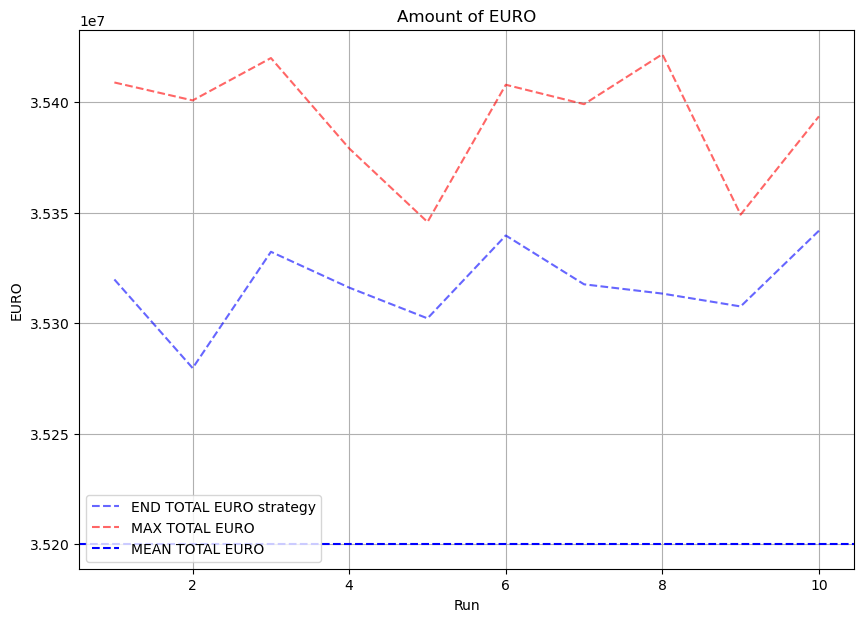

In [81]:
list_of_end_euros = [35319731.40730541, 35279643.45552034, 35332247.8983873, 35316032.78494922, 35302140.46293305, 35339620.57943907, 35317534.11894101, 35313344.545446604, 35307529.948181115, 35341773.62717832]
list_of_max_end_euros = [35408815.30495261, 35400708.46191451, 35419860.37496236, 35378978.88147055, 35345720.33066683, 35407787.36521787, 35398991.880421616, 35421590.89709132, 35349043.574277334, 35393485.95643037]
runs = [1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(10, 7))
plt.plot(runs, list_of_end_euros, 'b--', alpha=0.6, label='END TOTAL EURO strategy')
plt.plot(runs, list_of_max_end_euros, 'r--', alpha=0.6, label='MAX TOTAL EURO')
plt.axhline(35200000, color='b', linestyle='--', label=f'MEAN TOTAL EURO')
plt.xlabel("Run")
plt.ylabel("EURO")
plt.title("Amount of EURO")
plt.legend()
plt.grid(True)
plt.show

0.8817641986511247
0.8782943626592589
Total final euros: 35315352.637326844
Buy times:  []
Sell times:  [1.03, 1.87, 2.92, 3.02, 4.37, 4.48]
Buy prices:  []
Sell prices:  [0.8817641986511247, 0.8817641986511247, 0.8817641986511247, 0.8838220230522943, 0.8817641986511247, 0.883730291243594]
End dollar: 0
End number of euros: 35315352.637326844


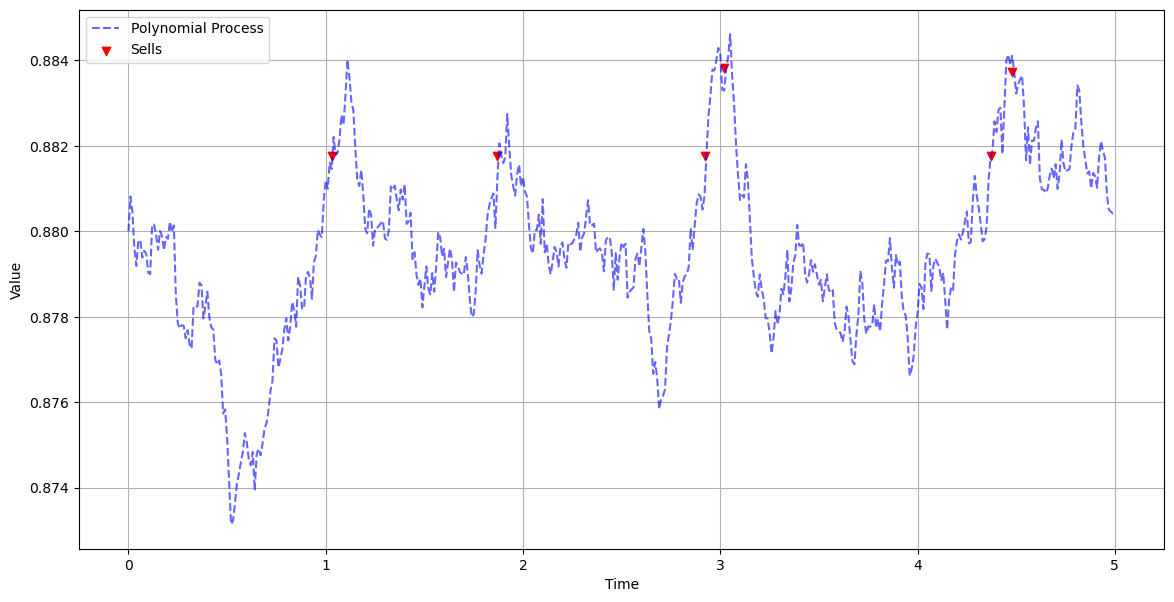

'\nfor i in range(10):\n    OU_path, POLY_path, end_dollars, end_euros, buy_times, sell_times, buy_prices, sell_prices = simulate_POLY_OU_process()\n    final_euros =  end_dollars * POLY_path[-1] + end_euros \n    list_of_end_euros.append(final_euros)\n    list_of_max_end_euros.append(40000000 * max(POLY_path))\n    list_of_end_dollars.append(end_dollars)\n    print(final_euros)\n    print(end_dollars)\n\nprint("Max euros: ", list_of_max_end_euros)\nprint("End euros: ", list_of_end_euros)\nprint("End dollars: ", list_of_end_dollars)\nmean = sum(list_of_end_euros) / 10\nprint("Mean: ", mean)\nvariance = np.var(list_of_end_euros)\nprint("Variance: ", variance)\nruns = [1,2,3,4,5,6,7,8,9,10]\n\nplt.figure(figsize=(14, 7))\nplt.plot(runs, list_of_end_euros, \'b--\', alpha=0.6, label=\'END TOTAL EURO strategy\')\nplt.plot(runs, list_of_max_end_euros, \'r--\', alpha=0.6, label=\'MAX TOTAL EURO\')\nplt.axhline(35200000, color=\'b\', linestyle=\'--\', label=f\'MEAN TOTAL EURO\')\nplt.xlabel("R

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.optimize import brentq
from mpmath import mp
from functools import lru_cache
from scipy.optimize import root_scalar
mp.dps = 10

# Parameters
theta = 3
mu = 0
sigma = 0.05
x_0_init = 0
p_0, p_1, p_2, p_3 = 0.88, 0.1, 0.1, 0.5
degree = 3
T = 5
m = 500
time_points = np.linspace(0, T, m + 1)
L, R = 0, 100
x_COS = np.linspace(L, R, 1000)
N = 512

# Capital
dollars = 40000000
euros = 0

# Target
target_prob = 0.8
a_bounds = (0.5, 1.5)
b_bounds = (0.5, 1.5)

# Polynomial inversion

def inv_poly(x):
    coeffs = [p_3, p_2, p_1, p_0 - x]
    roots = np.roots(coeffs)
    real_roots = roots[np.isreal(roots)].real
    return real_roots[np.argmax(real_roots)]  # Take the largest real root

# Characteristic functions

def phi_upper(u, a, x_0):
    y1 = ((mu - x_0) * np.sqrt(2 * theta)) / sigma
    y2 = ((mu - inv_poly(a)) * np.sqrt(2 * theta)) / sigma
    exp_factor = np.exp((theta * (x_0 - mu) ** 2 - theta * (inv_poly(a) - mu) ** 2) / (2 * sigma ** 2))
    v = mp.mpc(0., -u / theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def phi_lower(u, b, x_0):
    mu_adj = 2 * x_0 - mu 
    y1 = ((mu_adj - x_0) * np.sqrt(2 * theta)) / sigma
    y2 = ((mu_adj - (2 * x_0 - inv_poly(b))) * np.sqrt(2 * theta)) / sigma
    exp_factor = np.exp((theta * (x_0 - mu_adj) ** 2 - theta * ((2 * x_0 - inv_poly(b)) - mu_adj) ** 2) / (2 * sigma ** 2))
    v = mp.mpc(0., -u / theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))



# COS density

def COSDensity(phi,x,N,R,L,q,p):
    sum = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi(k*np.pi/(R-L),q,p ) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k = 0.5 * F_k
        else:
            F_k = F_k
        F_k = F_k *np.exp(np.log(10**(-16))*(k/N)**6)
        sum += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum

# Hitting probability
def hitting_probability(func, barrier, x_0):
    pdf = COSDensity(func, x_COS, N, R,L, barrier,x_0)
    mask = x_COS <= 1
    return simps(pdf[mask], x_COS[mask])

# Faster barrier distance calculation
def find_price_barrier(phi_func, x_0, P_x0, direction='upper', max_barrier=0.05):
    def obj(barrier):
        return hitting_probability(phi_func, barrier, x_0) - target_prob

    if direction == 'upper':
        bracket = [P_x0 + 0.0001, P_x0 + max_barrier]
    else:  # 'lower'
        bracket = [P_x0 - max_barrier, P_x0 - 0.0001]

    sol = root_scalar(obj, bracket=bracket, method='brentq', rtol=1e-5)
    return sol.root


# Simulate

def simulate_POLY_OU_process():
    dt = T / m
    OU_path = np.zeros(m + 1)
    POLY_path = np.zeros(m + 1)
    OU_path[0] = x_0_init
    POLY_path[0] = p_0 + p_1 * x_0_init + p_2 * x_0_init ** 2 + p_3 * x_0_init ** 3
    dW = np.sqrt(dt) * np.random.normal(0, 1, m)
    dollars_local, euros_local = dollars, euros
    x_0 = x_0_init
    P_x0 = p_0 + p_1 * x_0 + p_2 * x_0 ** 2 + p_3 * x_0 ** 3

    last_trade_time = -np.inf  # initialize with a very small value
    min_trade_interval = 0.1  # days

    a = find_price_barrier(phi_upper, x_0, P_x0, direction='upper')
    b = find_price_barrier(phi_lower, x_0, P_x0, direction='lower')
    x_a = a
    x_b = b
    print(a)
    print(b)
    
    buy_times = []
    sell_times = []
    buy_prices = []
    sell_prices = []

    for j in range(m):
        current_time = (j / m) * T
        x_next = OU_path[j] + theta * (mu - OU_path[j]) * dt + sigma * dW[j]
        OU_path[j + 1] = x_next
        P_x = p_0 + p_1 * x_next + p_2 * x_next ** 2 + p_3 * x_next ** 3
        POLY_path[j + 1] = P_x

        if current_time - last_trade_time >= min_trade_interval:

            if P_x >= a and dollars_local >= 5000000:
                if 0.88 < a <= x_a:
                    dollars_local -= 5000000
                    euros_local += 5000000 * P_x
                    last_trade_time = current_time
                    x_start = x_next
                    sell_prices.append(a)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    if b > 0.88:
                        print(f"[Adjustment] Lower barrier {b:.4f} is above 0.88. Resetting to 0.88.")
                        b = 0.88
                    sell_times.append(np.round((j/m)*T,3))
                elif a != 0.88 and a > x_a and dollars_local >= 10000000:
                    dollars_local -= 10000000
                    euros_local += 10000000 * P_x
                    last_trade_time = current_time
                    x_start = x_next
                    sell_prices.append(P_x)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    if b > 0.88:
                        print(f"[Adjustment] Lower barrier {b:.4f} is above 0.88. Resetting to 0.88.")
                        b = 0.88
                    sell_times.append(np.round((j/m)*T,3))
                elif a != 0.88 and a > x_a and dollars_local >= 5000000:
                    dollars_local -= 5000000
                    euros_local += 5000000 * P_x
                    last_trade_time = current_time
                    x_start = x_next
                    sell_prices.append(P_x)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    if b > 0.88:
                        print(f"[Adjustment] Lower barrier {b:.4f} is above 0.88. Resetting to 0.88.")
                        b = 0.88
                    sell_times.append(np.round((j/m)*T,3))
                else:
                    x_start = x_next
                    a = x_a
                    b = x_b
                        
            elif P_x <= b:
                if b >=  0.88:
                    x_start = x_next
                    buy_prices.append(b)
                    a = find_price_barrier(phi_upper, x_start, P_x, direction='upper')
                    b = find_price_barrier(phi_lower, x_start, P_x, direction='lower')
                    buy_times.append(np.round((j/m)*T, 3))
    
                else:
                    a = x_a
                    b = b - 1
            else:
                continue

        else: 
            continue

    return OU_path, POLY_path, dollars_local, euros_local, buy_times, sell_times, buy_prices, sell_prices

# Run simulation
"""
if a < 0.88:
                    print(f"[Adjustment] Upper barrier {a:.4f} is below 0.88. Resetting to 0.88.")
                    a = 0.88
"""

OU_path, POLY_path, end_dollars, end_euros, buy_times, sell_times, buy_prices, sell_prices = simulate_POLY_OU_process()
final_euros =  end_dollars * POLY_path[-1] + end_euros 
print('Total final euros:', final_euros)
print("Buy times: " ,buy_times)
print("Sell times: " ,sell_times)
print("Buy prices: " ,buy_prices)
print("Sell prices: " ,sell_prices)
print("End dollar:", end_dollars)
print("End number of euros:", end_euros)

# Plot

dt = T / m
plt.figure(figsize=(14, 7))
#plt.plot(time_points, OU_path, 'r-', alpha=0.6, label='OU Process')
plt.plot(time_points, POLY_path, 'b--', alpha=0.6, label='Polynomial Process')
plt.scatter(sell_times, sell_prices, color='red', marker='v', label='Sells')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

list_of_end_euros = []
list_of_max_end_euros = []
list_of_end_dollars = []
mean_end_dollars = 3520000

"""
for i in range(10):
    OU_path, POLY_path, end_dollars, end_euros, buy_times, sell_times, buy_prices, sell_prices = simulate_POLY_OU_process()
    final_euros =  end_dollars * POLY_path[-1] + end_euros 
    list_of_end_euros.append(final_euros)
    list_of_max_end_euros.append(40000000 * max(POLY_path))
    list_of_end_dollars.append(end_dollars)
    print(final_euros)
    print(end_dollars)

print("Max euros: ", list_of_max_end_euros)
print("End euros: ", list_of_end_euros)
print("End dollars: ", list_of_end_dollars)
mean = sum(list_of_end_euros) / 10
print("Mean: ", mean)
variance = np.var(list_of_end_euros)
print("Variance: ", variance)
runs = [1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(14, 7))
plt.plot(runs, list_of_end_euros, 'b--', alpha=0.6, label='END TOTAL EURO strategy')
plt.plot(runs, list_of_max_end_euros, 'r--', alpha=0.6, label='MAX TOTAL EURO')
plt.axhline(35200000, color='b', linestyle='--', label=f'MEAN TOTAL EURO')
plt.xlabel("Run")
plt.ylabel("EURO")
plt.title("Amount of EURO")
plt.legend()
plt.grid(True)
plt.show
"""